# Import Libraries

In [390]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load the movies.csv file

In [391]:
movies = pd.read_csv('movies.csv')

In [392]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [393]:
movies.shape

(58098, 3)

# Clean the movie titles by removing extra whitespace and punctuation marks

In [394]:
movies['title'] = movies['title'].str.strip()
movies['title'] = movies['title'].str.replace('[^\w\s]', '')

C:\Users\User\AppData\Local\Temp\ipykernel_10044\3350034636.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  movies['title'] = movies['title'].str.replace('[^\w\s]', '')


# Load the ratings.csv file

In [395]:
ratings = pd.read_csv('ratings.csv')

In [396]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [397]:
ratings.shape

(27753444, 4)

# Drop the timestamp column from the ratings dataframe

In [398]:
ratings = ratings.drop('timestamp', axis=1)

# Check for any missing or duplicate data in the ratings dataframe

In [399]:
print('Missing values in ratings:\n', ratings.isnull().sum())
print('Duplicate values in ratings:', ratings.duplicated().sum())

Missing values in ratings:
 userId     0
movieId    0
rating     0
dtype: int64
Duplicate values in ratings: 0


# Load the tags.csv file

In [400]:
tags = pd.read_csv('tags.csv')

In [401]:
tags.head()

,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195


In [402]:
tags.shape

(1108997, 4)

# Drop the timestamp column from the tags dataframe

In [403]:
tags = tags.drop('timestamp', axis=1)

# Check for any missing or duplicate data in the tags dataframe

In [404]:
print('Missing values in tags:\n', tags.isnull().sum())
print('Duplicate values in tags:', tags.duplicated().sum())

Missing values in tags:
 userId      0
movieId     0
tag        16
dtype: int64
Duplicate values in tags: 0


# Merge the movies, ratings, and tags data into a single DataFrame

In [405]:
data = pd.merge(movies, ratings, on='movieId')
data = pd.merge(data, tags, on=['userId', 'movieId'])

# Check for any missing or duplicate data in the merged dataframe

In [406]:
print('Missing values in data:\n', data.isnull().sum())
print('Duplicate values in data:', data.duplicated().sum())

Missing values in data:
 movieId    0
title      0
genres     0
userId     0
rating     0
tag        1
dtype: int64
Duplicate values in data: 0


In [407]:
data.head()

,movieId,title,genres,userId,rating,tag
0,1,Toy Story 1995,Adventure|Animation|Children|Comedy|Fantasy,1040,2.5,animated
1,1,Toy Story 1995,Adventure|Animation|Children|Comedy|Fantasy,1040,2.5,buddy movie
2,1,Toy Story 1995,Adventure|Animation|Children|Comedy|Fantasy,1040,2.5,Cartoon
3,1,Toy Story 1995,Adventure|Animation|Children|Comedy|Fantasy,1040,2.5,cgi
4,1,Toy Story 1995,Adventure|Animation|Children|Comedy|Fantasy,1040,2.5,comedy


In [408]:
data.shape

(830492, 6)

# Convert movie titles to numerical IDs

In [409]:
movie_id_to_name = dict(zip(data['movieId'].unique(), range(len(data['movieId'].unique()))))
data['movieId'] = data['movieId'].map(movie_id_to_name)

In [410]:
import numpy as np

# Convert user IDs to numerical IDs

In [411]:
user_id_to_name = dict(zip(data['userId'].unique(), range(len(data['userId'].unique()))))
data['userId'] = data['userId'].map(user_id_to_name)

# Split the data into training, validation, and testing sets

In [412]:
train_data, test_data = train_test_split(data, test_size=0.15, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)


# Create sequences of movie IDs for each user

In [413]:
# Create a vocabulary of all unique movie IDs
vocabulary = sorted(data['movieId'].unique())


In [414]:
# Define the vocabulary size and sequence length
vocabulary_size = len(vocabulary)
max_sequence_length = 200

In [415]:

def create_sequences(data, vocabulary, max_sequence_length):
    sequences = []
    for user_id, group in data.groupby('userId'):
        movie_ids = group['movieId'].values
        sequence = [vocabulary.index(movie_id) + 1 for movie_id in movie_ids if movie_id in vocabulary]
        if len(sequence) > max_sequence_length:
            sequence = sequence[:max_sequence_length]
        else:
            sequence = sequence + [0] * (max_sequence_length - len(sequence))
        sequences.append(sequence)
    return np.array(sequences)


In [416]:
# Create sequences of movie IDs for each user
train_sequences = create_sequences(train_data, vocabulary, max_sequence_length)
val_sequences = create_sequences(val_data, vocabulary, max_sequence_length)
test_sequences = create_sequences(test_data, vocabulary, max_sequence_length)

In [417]:
train_data.size

3388404

In [418]:
print(train_sequences)

[[ 9697  8684  8064 ...  8315  3192   507]
 [ 3093   937  3255 ...  1109  2988  7746]
 [    1 12681     1 ...     0     0     0]
 ...
 [21891 21891 21891 ...     0     0     0]
 [21913 21913     0 ...     0     0     0]
 [21935 21935 21935 ...     0     0     0]]


In [419]:
print(train_sequences.shape)

(15116, 200)


In [420]:

print("Minimum value:", np.min(train_sequences))
print("Maximum value:", np.max(train_sequences))


Minimum value: 0
Maximum value: 21942


In [421]:
val_data.size

847104

In [422]:
print(val_sequences)

[[ 8064  8064  7785 ...  2166  3762  1176]
 [ 1132  1449  7417 ...  3762  2988  3791]
 [  758     1     0 ...     0     0     0]
 ...
 [21910 21907     0 ...     0     0     0]
 [21782 21938     0 ...     0     0     0]
 [21864     0     0 ...     0     0     0]]


In [423]:
print(val_sequences.shape)

(9678, 200)


In [424]:

print("Minimum value:", np.min(val_sequences))
print("Maximum value:", np.max(val_sequences))

Minimum value: 0
Maximum value: 21942


In [425]:
test_data.size

747444

In [426]:
print(test_sequences)

[[14978 15622 10857 ...  1365   676 14978]
 [ 7746     1  1942 ...  3257  2332  1140]
 [    1   488  6086 ...     0     0     0]
 ...
 [21877     0     0 ...     0     0     0]
 [21886     0     0 ...     0     0     0]
 [21913     0     0 ...     0     0     0]]


In [427]:
print(test_sequences.shape)

(9192, 200)


In [428]:
print("Minimum value:", np.min(test_sequences))
print("Maximum value:", np.max(test_sequences))

Minimum value: 0
Maximum value: 21942


In [429]:
from keras_preprocessing.sequence import pad_sequences

# Pad sequences with zeros to make them the same length

In [430]:
max_sequence_length = 200

In [431]:
train_sequences_padded = pad_sequences(train_sequences.tolist(), maxlen=max_sequence_length, padding='post', truncating='post')
val_sequences_padded = pad_sequences(val_sequences.tolist(), maxlen=max_sequence_length, padding='post', truncating='post')
test_sequences_padded = pad_sequences(test_sequences.tolist(), maxlen=max_sequence_length, padding='post', truncating='post')


In [432]:
test_max_movie_id = np.max(test_sequences_padded)
print(test_max_movie_id)


21942


In [433]:
train_sequences_padded.shape

(15116, 200)

In [434]:
val_sequences_padded.shape


(9678, 200)

In [435]:
test_sequences_padded.shape

(9192, 200)

# Define the RNN model

In [436]:
# Get the maximum movie ID
max_movie_id = data['movieId'].max()

# Define the embedding size
embedding_size = 64


In [437]:
print(max_movie_id)

21941


In [438]:
print(max_sequence_length)

200


In [444]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<OOV>") #to remove the out of vocabulary(OOV)


In [445]:
# Define integer encoding function
def integer_encode_sequences(sequences, num_movies):
    encoded_sequences = []
    for sequence in sequences:
        encoded_sequence = []
        for movie_id in sequence:
            encoded_sequence.append(movie_id-1) # subtract 1 to make movie IDs start from 0
        encoded_sequences.append(encoded_sequence)
    return encoded_sequences

# Integer encode sequences
y_train = np.array(integer_encode_sequences([seq[:200] for seq in train_sequences_padded], max_movie_id))
y_val = np.array(integer_encode_sequences([seq[:200] for seq in val_sequences_padded], max_movie_id))
y_test = np.array(integer_encode_sequences([seq[:200] for seq in test_sequences_padded], max_movie_id))


In [446]:
X_train = np.array(integer_encode_sequences([seq[:200] for seq in train_sequences_padded], max_movie_id))
X_val = np.array(integer_encode_sequences([seq[:200] for seq in val_sequences_padded], max_movie_id))
X_test = np.array(integer_encode_sequences([seq[:200] for seq in test_sequences_padded], max_movie_id))

In [447]:
test_max_movie_id = np.max(test_sequences_padded)
print(test_max_movie_id)


21942


In [448]:
y_train.shape

(15116, 200)

In [449]:
X_train.shape

(15116, 200)

In [450]:
y_val.shape

(9678, 200)

In [451]:
X_val.shape

(9678, 200)

In [452]:
y_test.shape

(9192, 200)

In [453]:
X_test.shape

(9192, 200)

In [462]:
print(y_train)

[[ 9696  8683  8063 ...  8314  3191   506]
 [ 3092   936  3254 ...  1108  2987  7745]
 [    0 12680     0 ...    -1    -1    -1]
 ...
 [21890 21890 21890 ...    -1    -1    -1]
 [21912 21912    -1 ...    -1    -1    -1]
 [21934 21934 21934 ...    -1    -1    -1]]


In [463]:
print(y_test)

[[14977 15621 10856 ...  1364   675 14977]
 [ 7745     0  1941 ...  3256  2331  1139]
 [    0   487  6085 ...    -1    -1    -1]
 ...
 [21876    -1    -1 ...    -1    -1    -1]
 [21885    -1    -1 ...    -1    -1    -1]
 [21912    -1    -1 ...    -1    -1    -1]]


In [464]:
print(y_val)

[[ 8063  8063  7784 ...  2165  3761  1175]
 [ 1131  1448  7416 ...  3761  2987  3790]
 [  757     0    -1 ...    -1    -1    -1]
 ...
 [21909 21906    -1 ...    -1    -1    -1]
 [21781 21937    -1 ...    -1    -1    -1]
 [21863    -1    -1 ...    -1    -1    -1]]


In [466]:
print(X_train)

[[ 9696  8683  8063 ...  8314  3191   506]
 [ 3092   936  3254 ...  1108  2987  7745]
 [    0 12680     0 ...    -1    -1    -1]
 ...
 [21890 21890 21890 ...    -1    -1    -1]
 [21912 21912    -1 ...    -1    -1    -1]
 [21934 21934 21934 ...    -1    -1    -1]]


In [467]:
print(X_test)

[[14977 15621 10856 ...  1364   675 14977]
 [ 7745     0  1941 ...  3256  2331  1139]
 [    0   487  6085 ...    -1    -1    -1]
 ...
 [21876    -1    -1 ...    -1    -1    -1]
 [21885    -1    -1 ...    -1    -1    -1]
 [21912    -1    -1 ...    -1    -1    -1]]


In [468]:
print(X_val)

[[ 8063  8063  7784 ...  2165  3761  1175]
 [ 1131  1448  7416 ...  3761  2987  3790]
 [  757     0    -1 ...    -1    -1    -1]
 ...
 [21909 21906    -1 ...    -1    -1    -1]
 [21781 21937    -1 ...    -1    -1    -1]
 [21863    -1    -1 ...    -1    -1    -1]]


In [477]:
y_train[y_train == -1] = max_movie_id+2
y_test[y_test == -1] = max_movie_id+2
y_val[y_val == -1] = max_movie_id+2

X_train[X_train == -1] = max_movie_id+2
X_test[X_test == -1] = max_movie_id+2
X_val[X_val == -1] = max_movie_id+2
# using max_movie_id +2 to replace the -1

In [478]:
print(y_train)

[[ 9696  8683  8063 ...  8314  3191   506]
 [ 3092   936  3254 ...  1108  2987  7745]
 [    0 12680     0 ...     0     0     0]
 ...
 [21890 21890 21890 ...     0     0     0]
 [21912 21912     0 ...     0     0     0]
 [21934 21934 21934 ...     0     0     0]]


In [479]:
print(y_test)

[[14977 15621 10856 ...  1364   675 14977]
 [ 7745     0  1941 ...  3256  2331  1139]
 [    0   487  6085 ...     0     0     0]
 ...
 [21876     0     0 ...     0     0     0]
 [21885     0     0 ...     0     0     0]
 [21912     0     0 ...     0     0     0]]


In [480]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.layers import LSTM, Embedding

lstm_size = 128

In [481]:
print(max_movie_id)

21941


# Define model

In [496]:
model = Sequential()
model.add(Embedding(max_movie_id+1, embedding_size, input_length=max_sequence_length, mask_zero=True))
model.add(LSTM(lstm_size, return_sequences=True))
model.add(Dense(max_movie_id+1, activation='softmax'))

# Compile the model

In [483]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with early stopping based on validation loss

In [484]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=15, batch_size=16, validation_data=(X_val, y_val), callbacks=[es_callback])


Epoch 1/15
945/945 [==============================] - 2318s 2s/step - loss: 0.7846 - accuracy: 0.0118 - val_loss: 0.4137 - val_accuracy: 0.0090
Epoch 2/15
945/945 [==============================] - 2300s 2s/step - loss: 0.6889 - accuracy: 0.0158 - val_loss: 0.3780 - val_accuracy: 0.0181
Epoch 3/15
945/945 [==============================] - 2298s 2s/step - loss: 0.5801 - accuracy: 0.0896 - val_loss: 0.2844 - val_accuracy: 0.2448
Epoch 4/15
945/945 [==============================] - 2309s 2s/step - loss: 0.3774 - accuracy: 0.4795 - val_loss: 0.1772 - val_accuracy: 0.6302
Epoch 5/15
945/945 [==============================] - 2305s 2s/step - loss: 0.2299 - accuracy: 0.7299 - val_loss: 0.1197 - val_accuracy: 0.7807
Epoch 6/15
945/945 [==============================] - 2304s 2s/step - loss: 0.1541 - accuracy: 0.8250 - val_loss: 0.0895 - val_accuracy: 0.8416
Epoch 7/15
945/945 [==============================] - 2311s 2s/step - loss: 0.1117 - accuracy: 0.8711 - val_loss: 0.0718 - val_accuracy:

In [488]:
history.history

{'loss': [0.7845688462257385,
  0.6889155507087708,
  0.5801008939743042,
  0.37743616104125977,
  0.22989071905612946,
  0.15407560765743256,
  0.11169424653053284,
  0.08390671759843826,
  0.06363310664892197,
  0.04811995476484299,
  0.03569976985454559,
  0.025718774646520615,
  0.017789868637919426,
  0.011583736166357994,
  0.007069962564855814],
 'accuracy': [0.01184919849038124,
  0.015763217583298683,
  0.08959051966667175,
  0.4795325994491577,
  0.7299427390098572,
  0.8250008225440979,
  0.8710516691207886,
  0.8999765515327454,
  0.9228445887565613,
  0.9434626698493958,
  0.9613419771194458,
  0.9784477949142456,
  0.992744505405426,
  0.9982790350914001,
  0.9996283650398254],
 'val_loss': [0.41373246908187866,
  0.3780372142791748,
  0.2844369411468506,
  0.1772121787071228,
  0.11974183470010757,
  0.08946289122104645,
  0.07184314727783203,
  0.05967116728425026,
  0.051097992807626724,
  0.04447370395064354,
  0.03927464783191681,
  0.034859657287597656,
  0.03151831

# Graph of the history

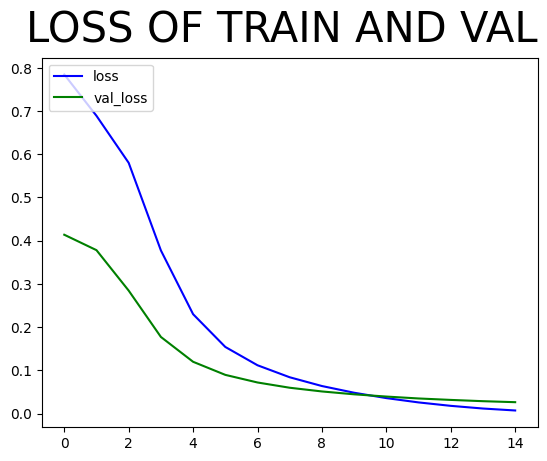

In [489]:
fig = plt.figure()
plt.plot(history.history['loss'], color='blue', label='loss')
plt.plot(history.history['val_loss'], color='green', label='val_loss')
fig.suptitle('LOSS OF TRAIN AND VAL', fontsize=30)
plt.legend(loc="upper left")
plt.show()

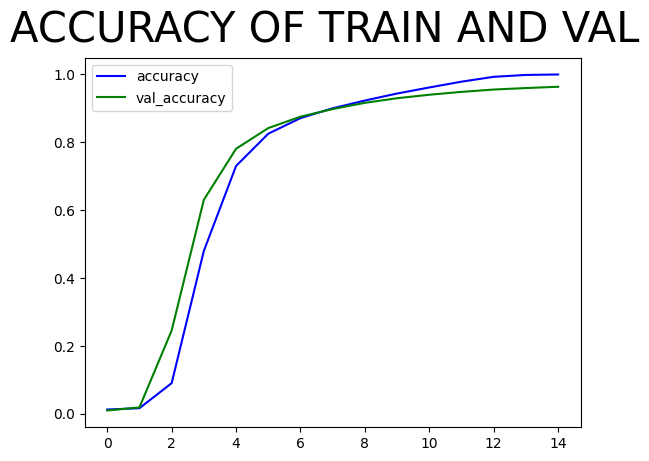

In [490]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='blue', label='accuracy')
plt.plot(history.history['val_accuracy'], color='green', label='val_accuracy')
fig.suptitle('ACCURACY OF TRAIN AND VAL', fontsize=30)
plt.legend(loc="upper left")
plt.show()

# Evaluate the model on the test set

In [492]:
test_loss, test_acc = model.evaluate(y_test, X_test)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')


288/288 [==============================] - 679s 2s/step - loss: 0.0253 - accuracy: 0.9633
Test loss: 0.0253
Test accuracy: 0.9633


# Save Model

In [493]:
from tensorflow.keras.models import load_model

In [494]:
import os

In [495]:
model.save(os.path.join('Model','MovieRecommendation_model.h5'))